In [6]:
import os
import numpy as np
import pandas as pd
from google.cloud import bigquery

# Get The Data

In [4]:
def get_bq_data(table):
    PROJECT = "le-wagon-hedge-fund"
    client = bigquery.Client(project=PROJECT)
    DATASET = "data_alpaca_20240604"
    query = f'''
    SELECT * FROM {PROJECT}.{DATASET}.{table}
    '''
    query_job = client.query(query)
    results = query_job.result()
    return results.to_dataframe()

In [12]:
from lwhf.data.biqquery import BigQueryData

PROJECT = "le-wagon-hedge-fund"
DATASET = "data_alpaca_20240604"
TABLE = "SP500_Historical_Weekly"

data = BigQueryData(PROJECT, DATASET, TABLE)

ModuleNotFoundError: No module named 'lwhf'

In [7]:

raw_data_dir = "../raw_data"
TABLE = "SP500_Historical_Weekly"
saved_table = f"{raw_data_dir}/{TABLE}.csv"
if not os.path.exists(saved_table):
    df = get_bq_data(TABLE)
    df.to_csv(saved_table, index=False)
else:
    df = pd.read_csv(saved_table)
df.shape

/Users/behnamnajafi/.pyenv/versions/3.10.6/envs/lwhf/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


(205923, 9)

In [11]:
df.pivot(
        index='timestamp',
        columns='symbol',
        values='close').info()

<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 2016-01-04 05:00:00+00:00 to 2024-05-27 04:00:00+00:00
Columns: 505 entries, A to ZTS
dtypes: float64(505)
memory usage: 1.7+ MB


# Preprocessing

In [4]:
import datetime, pytz
df['timestamp'] = pd.to_datetime(df['timestamp'])
# start_date = datetime.datetime(2016,1,1,0,0,0,0,pytz.UTC)
# df = df[df['timestamp'] > start_date]
df = df[['symbol','timestamp', 'close']]
df.shape

(205923, 3)

In [5]:
max_count = df['symbol'].value_counts().max()
max_count

439

In [6]:
#stocks_in_universe = df['symbol'].value_counts().iloc[:10]
stocks_in_universe = df['symbol'].value_counts().loc[df['symbol'].value_counts()>max_count-1]

df = df[df['symbol'].isin(stocks_in_universe.index)]

In [7]:
start_date = df['timestamp'].min()
# get number of weeks from start_date
df['week'] = (df['timestamp'] - start_date).dt.days / 7
df

,symbol,timestamp,close,week
0,AAPL,2016-01-04 05:00:00+00:00,96.96,0.000000
1,AAPL,2016-01-11 05:00:00+00:00,97.13,1.000000
2,AAPL,2016-01-18 05:00:00+00:00,101.42,2.000000
3,AAPL,2016-01-25 05:00:00+00:00,97.34,3.000000
4,AAPL,2016-02-01 05:00:00+00:00,94.02,4.000000
...,...,...,...,...
205918,ZTS,2024-04-29 04:00:00+00:00,167.07,433.857143
205919,ZTS,2024-05-06 04:00:00+00:00,169.04,434.857143
205920,ZTS,2024-05-13 04:00:00+00:00,174.06,435.857143
205921,ZTS,2024-05-20 04:00:00+00:00,170.07,436.857143


In [8]:
closes = df.drop(
    'week',
    axis=1
    ).pivot(
        index='timestamp',
        columns='symbol',
        values='close')
closes

symbol,A,AAL,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-04 05:00:00+00:00,38.59,40.37,145.56,96.96,55.65,40.67,98.20,87.85,49.98,34.39,...,57.74,36.18,74.69,56.99,9.59,34.37,68.14,101.55,24.60,45.88
2016-01-11 05:00:00+00:00,37.11,38.76,144.29,97.13,57.34,40.54,99.27,89.17,49.82,31.51,...,58.37,36.50,77.58,56.49,9.10,32.98,67.09,101.08,22.34,43.38
2016-01-18 05:00:00+00:00,37.98,40.16,144.43,101.42,58.83,40.03,102.24,89.63,51.38,33.23,...,59.17,36.63,76.57,57.52,9.07,34.03,68.98,99.15,21.51,43.40
2016-01-25 05:00:00+00:00,37.65,38.99,152.05,97.34,54.90,37.85,105.54,89.13,53.86,35.35,...,67.34,38.22,77.85,58.89,9.75,35.95,72.37,99.26,22.68,43.05
2016-02-01 05:00:00+00:00,36.04,36.75,143.94,94.02,53.12,37.41,98.97,79.20,49.82,34.07,...,61.91,39.53,80.08,58.99,9.46,36.66,69.76,95.01,21.63,40.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29 04:00:00+00:00,139.45,13.85,76.31,183.38,163.79,105.90,303.71,486.18,199.63,59.17,...,96.71,54.25,116.00,28.29,13.36,137.21,134.34,121.66,43.62,167.07
2024-05-06 04:00:00+00:00,149.76,14.40,75.03,183.05,160.75,104.74,306.33,482.29,207.19,62.98,...,96.39,55.46,117.96,27.89,13.54,143.00,137.62,121.31,44.32,169.04
2024-05-13 04:00:00+00:00,154.23,14.73,74.55,189.87,166.42,104.09,303.59,483.43,214.08,61.62,...,96.79,55.52,119.64,28.28,13.95,143.32,141.66,120.18,44.96,174.06


## change the index to have a consistent frequency

In [9]:
# check the frequency of the index

closes.index.to_series().diff().value_counts()

timestamp
7 days 00:00:00    421
6 days 23:00:00      9
7 days 01:00:00      8
Name: count, dtype: int64

In [10]:
new_index = pd.date_range(start=start_date, periods=len(closes), freq='7D')
closes.index = new_index
closes.index.to_series().diff().value_counts()
closes.index.name = 'timestamp'

In [11]:
closes_weekly = df.drop(
    'timestamp',
    axis=1
    ).pivot(
        index='week',
        columns='symbol',
        values='close')
closes_weekly.index = closes_weekly.index.round(0).astype(int)
closes_weekly

symbol,A,AAL,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
week,,,,,,,,,,,,,,,,,,,,,
0,38.59,40.37,145.56,96.96,55.65,40.67,98.20,87.85,49.98,34.39,...,57.74,36.18,74.69,56.99,9.59,34.37,68.14,101.55,24.60,45.88
1,37.11,38.76,144.29,97.13,57.34,40.54,99.27,89.17,49.82,31.51,...,58.37,36.50,77.58,56.49,9.10,32.98,67.09,101.08,22.34,43.38
2,37.98,40.16,144.43,101.42,58.83,40.03,102.24,89.63,51.38,33.23,...,59.17,36.63,76.57,57.52,9.07,34.03,68.98,99.15,21.51,43.40
3,37.65,38.99,152.05,97.34,54.90,37.85,105.54,89.13,53.86,35.35,...,67.34,38.22,77.85,58.89,9.75,35.95,72.37,99.26,22.68,43.05
4,36.04,36.75,143.94,94.02,53.12,37.41,98.97,79.20,49.82,34.07,...,61.91,39.53,80.08,58.99,9.46,36.66,69.76,95.01,21.63,40.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,139.45,13.85,76.31,183.38,163.79,105.90,303.71,486.18,199.63,59.17,...,96.71,54.25,116.00,28.29,13.36,137.21,134.34,121.66,43.62,167.07
435,149.76,14.40,75.03,183.05,160.75,104.74,306.33,482.29,207.19,62.98,...,96.39,55.46,117.96,27.89,13.54,143.00,137.62,121.31,44.32,169.04
436,154.23,14.73,74.55,189.87,166.42,104.09,303.59,483.43,214.08,61.62,...,96.79,55.52,119.64,28.28,13.95,143.32,141.66,120.18,44.96,174.06


In [12]:
returns = closes.pct_change().dropna()
returns

symbol,A,AAL,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-11 05:00:00+00:00,-0.038352,-0.039881,-0.008725,0.001753,0.030368,-0.003196,0.010896,0.015026,-0.003201,-0.083745,...,0.010911,0.008845,0.038693,-0.008773,-0.051095,-0.040442,-0.015409,-0.004628,-0.091870,-0.054490
2016-01-18 05:00:00+00:00,0.023444,0.036120,0.000970,0.044168,0.025985,-0.012580,0.029918,0.005159,0.031313,0.054586,...,0.013706,0.003562,-0.013019,0.018233,-0.003297,0.031837,0.028171,-0.019094,-0.037153,0.000461
2016-01-25 05:00:00+00:00,-0.008689,-0.029133,0.052759,-0.040229,-0.066803,-0.054459,0.032277,-0.005578,0.048268,0.063798,...,0.138077,0.043407,0.016717,0.023818,0.074972,0.056421,0.049145,0.001109,0.054393,-0.008065
2016-02-01 05:00:00+00:00,-0.042762,-0.057451,-0.053338,-0.034107,-0.032423,-0.011625,-0.062251,-0.111410,-0.075009,-0.036209,...,-0.080636,0.034275,0.028645,0.001698,-0.029744,0.019750,-0.036065,-0.042817,-0.046296,-0.049710
2016-02-08 05:00:00+00:00,0.004994,0.029116,-0.022023,-0.000319,-0.010166,-0.007485,-0.043144,-0.031944,-0.003613,-0.047549,...,0.116782,-0.017961,0.011863,-0.072216,-0.072939,0.010366,-0.034690,-0.033996,-0.029589,-0.011733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29 05:00:00+00:00,0.012415,-0.002161,0.015571,0.083166,0.026125,-0.015159,-0.013961,0.018050,-0.011586,-0.015474,...,0.008657,0.005374,-0.016616,-0.074583,-0.045714,0.036329,-0.052409,0.019355,0.044540,0.054602
2024-05-06 05:00:00+00:00,0.073933,0.039711,-0.016774,-0.001800,-0.018560,-0.010954,0.008627,-0.008001,0.037870,0.064391,...,-0.003309,0.022304,0.016897,-0.014139,0.013473,0.042198,0.024416,-0.002877,0.016048,0.011791
2024-05-13 05:00:00+00:00,0.029848,0.022917,-0.006397,0.037258,0.035272,-0.006206,-0.008945,0.002364,0.033255,-0.021594,...,0.004150,0.001082,0.014242,0.013984,0.030281,0.002238,0.029356,-0.009315,0.014440,0.029697


In [13]:
cov_returns = returns.cov()
cov_returns

symbol,A,AAL,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
symbol,,,,,,,,,,,,,,,,,,,,,
A,0.001200,0.000889,0.000683,0.000646,0.000431,0.000638,0.000677,0.000784,0.000771,0.000470,...,0.000861,0.000272,0.000430,0.000656,0.000768,0.000755,0.000519,0.000679,0.000763,0.000727
AAL,0.000889,0.006024,0.001522,0.000840,0.000480,0.000545,0.001003,0.000826,0.001303,0.000818,...,0.002813,0.000466,0.001176,0.001451,0.001905,0.001421,0.001227,0.001300,0.002204,0.000796
AAP,0.000683,0.001522,0.003086,0.000642,0.000737,0.000595,0.000770,0.000608,0.000705,0.000688,...,0.001256,0.000606,0.000756,0.000886,0.001323,0.000799,0.000893,0.000827,0.001201,0.000682
AAPL,0.000646,0.000840,0.000642,0.002765,0.000461,0.000634,0.000719,0.001010,0.000799,0.000307,...,0.000938,0.000348,0.000323,0.000559,0.000587,0.000595,0.000610,0.000603,0.000485,0.000722
ABBV,0.000431,0.000480,0.000737,0.000461,0.001325,0.000557,0.000434,0.000411,0.000336,0.000336,...,0.000580,0.000344,0.000414,0.000524,0.000740,0.000486,0.000442,0.000555,0.000551,0.000538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.000755,0.001421,0.000799,0.000595,0.000486,0.000556,0.000697,0.000617,0.000745,0.000556,...,0.001216,0.000457,0.000548,0.000751,0.000991,0.001416,0.000769,0.000737,0.000963,0.000694
YUM,0.000519,0.001227,0.000893,0.000610,0.000442,0.000539,0.000602,0.000510,0.000608,0.000424,...,0.001232,0.000556,0.000518,0.000643,0.000887,0.000769,0.001309,0.000792,0.000705,0.000582
ZBH,0.000679,0.001300,0.000827,0.000603,0.000555,0.000647,0.000673,0.000669,0.000728,0.000565,...,0.001226,0.000449,0.000660,0.000938,0.001147,0.000737,0.000792,0.001527,0.000902,0.000618


In [14]:
closes.to_csv(f"{raw_data_dir}/closes.csv", index=True)

In [15]:
returns.to_csv(f"{raw_data_dir}/returns.csv", index=True)

# Portfolio Optimization

In [151]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [152]:
# # Calculate expected returns and sample covariance
# mu = expected_returns.mean_historical_return(closes)
# S = risk_models.sample_cov(closes)
# ef = EfficientFrontier(mu, S)
# weights = ef.max_sharpe()
# ef.portfolio_performance(verbose=True)

In [153]:
from pypfopt.risk_models import CovarianceShrinkage

mu = expected_returns.mean_historical_return(closes)
S = CovarianceShrinkage(closes).ledoit_wolf()

In [154]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.txt")  # saves to file
display(cleaned_weights)

OrderedDict([('AAPL', 0.0),
             ('M', 0.0),
             ('MOS', 0.0),
             ('MS', 0.0),
             ('MSFT', 0.62971),
             ('MSI', 0.23848),
             ('MTB', 0.0),
             ('MTD', 0.0),
             ('MU', 0.13181),
             ('NAVI', 0.0)])

# Time Series Models

In [193]:
closes

symbol,AAPL,M,MOS,MS,MSFT,MSI,MTB,MTD,MU,NAVI
timestamp,,,,,,,,,,
2016-01-04 05:00:00+00:00,96.96,35.89,24.91,28.38,52.33,64.25,110.17,313.93,13.33,10.18
2016-01-11 05:00:00+00:00,97.13,37.88,25.47,25.97,50.99,61.59,104.49,313.62,11.08,9.00
2016-01-18 05:00:00+00:00,101.42,41.35,23.85,25.61,52.29,62.04,104.58,316.25,11.07,9.24
2016-01-25 05:00:00+00:00,97.34,40.41,24.10,25.88,55.09,66.77,110.18,312.85,11.03,9.56
2016-02-01 05:00:00+00:00,94.02,40.26,24.86,24.35,50.16,62.82,107.80,311.68,11.00,9.51
...,...,...,...,...,...,...,...,...,...,...
2024-04-29 05:00:00+00:00,183.38,19.52,28.68,93.64,406.66,353.70,146.58,1251.95,114.70,15.98
2024-05-06 05:00:00+00:00,183.05,19.35,29.43,98.28,414.74,362.85,153.66,1510.25,121.24,15.48
2024-05-13 05:00:00+00:00,189.87,19.49,30.61,100.22,420.21,367.80,153.79,1522.75,125.29,15.42


In [164]:
from darts.timeseries import TimeSeries

series = TimeSeries.from_dataframe(closes).astype(np.float32)
train, test = series.split_after(0.8)

# change the series to float32


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


In [173]:
from darts.models import RNNModel
model = RNNModel(
    input_chunk_length=1,
    model='LSTM',
    hidden_dim=20,
    n_rnn_layers=1,
    training_length=len(train))


In [174]:
model.fit(series, verbose=True, epochs=25)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.6 K 
4 | V             | Linear           | 210   
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 45.93it/s, train_loss=1.18e+5]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 45.53it/s, train_loss=1.18e+5]


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=351, input_chunk_length=1)

In [175]:
preds = model.predict(n=len(test))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s]


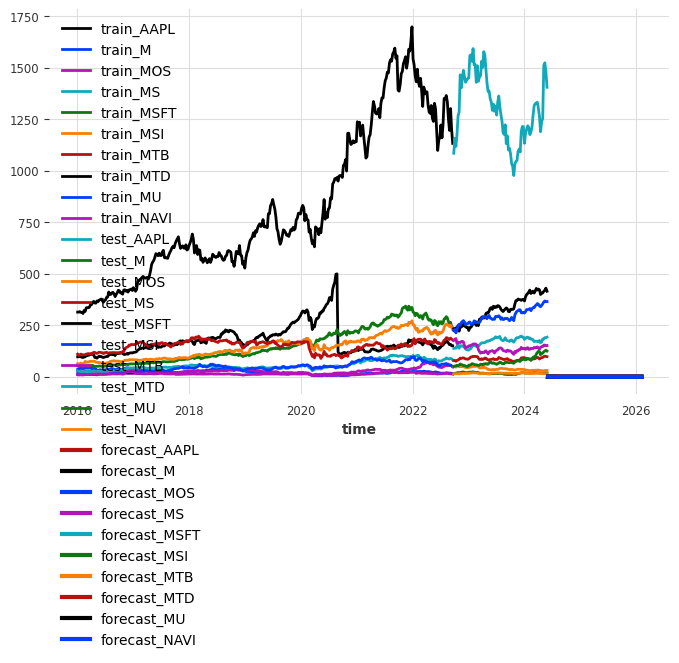

In [172]:
# plot the forecast with the actual data

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
train.plot(label='train')
test.plot(label='test')
preds.plot(label='forecast', lw=3)
plt.legend()
